In [10]:
# Read the dataset
import scipy.io as spio
import numpy as np

BahramFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/BahramFace.mat')
DJFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/DJFace.mat')
NickFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/NickFace.mat')
RoohiFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/RoohiFace.mat')
SarahFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/SarahFace.mat')

AllData = np.concatenate((BahramFace['Intensification_Data'],
                            DJFace['Intensification_Data'],
                            NickFace['Intensification_Data'],
                            RoohiFace['Intensification_Data'],
                            SarahFace['Intensification_Data']), axis=0)

AllLabels = np.concatenate((BahramFace['Intensification_Label'],
                            DJFace['Intensification_Label'],
                            NickFace['Intensification_Label'],
                            RoohiFace['Intensification_Label'],
                            SarahFace['Intensification_Label']), axis=0)

print(AllData.shape, AllData.dtype, AllLabels.shape, AllLabels.dtype)
print(np.mean(AllLabels==0), np.mean(AllLabels==1), np.mean(AllLabels==2), np.mean(AllLabels==3))
print((AllLabels +  1).max(axis=0))

(18720, 205, 16) float64 (18720, 1) uint8
0.833333333333 0.166666666667 0.0 0.0
[2]


In [11]:
# Train and test split
from sklearn.model_selection import train_test_split

X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(AllData, AllLabels, test_size=0.30)

print(X_train_valid.shape, X_test.shape, Y_train_valid.shape, Y_test.shape)

(13104, 205, 16) (5616, 205, 16) (13104, 1) (5616, 1)


In [12]:
from utilities import *

# Normalizing/standardizing the input data features
X_train_valid_norm, X_test_norm = standardize(test=X_test, train=X_train_valid)

# Onehot encoding/vectorizing the output data labels
print(np.mean((Y_train_valid+1).reshape(-1)==0), np.mean((Y_train_valid+1).reshape(-1)==1),
     np.mean((Y_train_valid+1).reshape(-1)==2), np.mean((Y_train_valid+1).reshape(-1)==3))

print(np.mean((Y_test+1).reshape(-1)==0), np.mean((Y_test+1).reshape(-1)==1),
     np.mean((Y_test+1).reshape(-1)==2), np.mean((Y_test+1).reshape(-1)==3))

# Y_train_valid_onehot = one_hot(labels=(Y_train_valid+1).reshape(-1), n_class=2) 
# print(Y_train_valid_onehot.shape, Y_train_valid_onehot.dtype, 
Y_test_onehot = one_hot(labels=(Y_test+1).reshape(-1), n_class=2) 
print(Y_test_onehot.shape, Y_test_onehot.dtype)

0.0 0.832799145299 0.167200854701 0.0
0.0 0.83457977208 0.16542022792 0.0
(5616, 2) float64


In [13]:
# X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(AllData, AllLabels, test_size=0.30)
X_train_norm, X_valid_norm, Y_train, Y_valid = train_test_split(X_train_valid_norm, Y_train_valid, 
                                                                              test_size=0.30)

In [14]:
def get_batches2(X_norm, Y_labels, kernel_size_ratio, strides_ratio):
    # X normalized and Y NOT onehot encoded/vectorized
    X, Y = X_norm, Y_labels
    AllLabels = Y_labels # 100%

    # non = 0 is 87%  AllLabelZero
    # tgt = 1 is 13%  AllLabelOne
    AllLabelZero = (AllLabels==0).reshape(-1) # 87%
    AllLabelOne = (AllLabels==1).reshape(-1) # 13%

    X_non, Y_non = X[AllLabelZero], Y[AllLabelZero] # 87%
    X_tgt, Y_tgt = X[AllLabelOne], Y[AllLabelOne] # 13%
#     print('X_non.shape, Y_non.shape', X_non.shape, Y_non.shape)
#     print('X_tgt.shape, Y_tgt.shape', X_tgt.shape, Y_tgt.shape)

    # Non-target batch size for get_batches from non-target data
    batch_size = X_tgt.shape[0] # 13% -> tgt = 1 is 13%  AllLabelOne
    assert X_tgt.shape[0] == Y_tgt.shape[0]
#     print('batch_size', batch_size)
    
    # Convolvolutional minibatching technique
    stride = batch_size
    pad = 0
    kernel_size = batch_size
    (inputs, filters, kernel_size, strides, padding) = (X_non, 1, int(batch_size//kernel_size_ratio), 
                                                        int(batch_size//strides_ratio), 0)
#     print('inputs.shape, filters, kernel_size, strides, padding', inputs.shape, filters, 
#           kernel_size, strides, padding)
    n_batches = int((inputs.shape[0] - kernel_size + (2*padding))//strides  + 1) 
#     print('n_batches', n_batches)
    
    # Loop over target batches: start, stop, step
    for i in range(0, n_batches, 1):
        each_X_norm = np.concatenate((X_non[(i*strides):((i*strides)+kernel_size)], X_tgt), axis=0)
        each_Y = np.concatenate((Y_non[(i*strides):((i*strides)+kernel_size)], Y_tgt), axis=0)
        each_Y_onehot = one_hot(labels=(each_Y+1).reshape(-1), n_class=2)
#         print('each_X_norm.shape, each_Y_onehot.shape', each_X_norm.shape, each_Y_onehot.shape)
#         print('np.mean(each_Y==0), np.mean(each_Y==1)', np.mean(each_Y==0), np.mean(each_Y==1))
        yield each_X_norm, each_Y_onehot

In [15]:
get_batches2(X_norm=X_valid_norm, Y_labels=Y_valid, kernel_size_ratio=1, strides_ratio=2)

<generator object get_batches2 at 0x7fc9158171a8>

In [16]:
get_batches2(X_norm=X_train_norm, Y_labels=Y_train, kernel_size_ratio=1, strides_ratio=2)

<generator object get_batches2 at 0x7fc91585dfc0>

In [17]:
## Hyperparameters
# Input data
# batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
# print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)
print('seq_len, n_channels', seq_len, n_channels)

# Output labels
n_classes = Y_train_valid.max(axis=0)+1
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)
print('n_classes', n_classes)

# learning parameters
learning_rate = 0.0001 #1e-4
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

seq_len, n_channels 205 16
n_classes [2]


In [18]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [19]:
# Feed the data from python/numpy to tensorflow framework
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')
print('inputs_.shape, labels_.shape', inputs_.shape, labels_.shape)

inputs_.shape, labels_.shape (?, 205, 16) (?, 2)


In [20]:
# inputs_.shape, labels_.shape (?, 205, 16) (?, 2)
# (batch, 205, 16) --> (batch, 102, 32)
# conv valid: (205-2+0)/1 + 1 = (203/1)+1 = 203 + 1=204
# pool same: (204-2+0)/2 + 1 = (202/2)+1 = 101 + 1=102
conv1 = tf.layers.conv1d(inputs=inputs_, filters=32, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
# max_pool_1 = tf.nn.dropout(max_pool_1, keep_prob=keep_prob_)
print('inputs_.shape, conv1.shape, max_pool_1.shape', inputs_.shape, conv1.shape, max_pool_1.shape)

# (batch, 102, 32) --> (batch, 51, 64)
# conv same
# pool same: (102-2+0)/2 + 1 = (100/2)+1 = 50 + 1=51
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=64, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
# max_pool_2 = tf.nn.dropout(max_pool_2, keep_prob=keep_prob_)
print('max_pool_1.shape, conv2.shape, max_pool_2.shape', max_pool_1.shape, conv2.shape, max_pool_2.shape)

# (batch, 51, 64) --> (batch, 25, 128)
# conv valid: (51-2+0)/1 + 1 = (49/1)+1 = 49 + 1=50
# pool same: (50-2+0)/2 + 1 = (48/2)+1 = 24 + 1=25
conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=128, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
# max_pool_3 = tf.nn.dropout(max_pool_3, keep_prob=keep_prob_)
print('max_pool_2.shape, conv3.shape, max_pool_3.shape', max_pool_2.shape, conv3.shape, max_pool_3.shape)

# (batch, 25, 128) --> (batch, 12, 256)
# conv valid: (25-2+0)/1 + 1 = (23/1)+1 = 23 + 1=24
# pool same: (24-2+0)/2 + 1 = (22/2)+1 = 11 + 1=12
conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=256, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
# max_pool_4 = tf.nn.dropout(max_pool_4, keep_prob=keep_prob_)
print('max_pool_3.shape, conv4.shape, max_pool_4.shape', max_pool_3.shape, conv4.shape, max_pool_4.shape)

# Flatten and add dropout + predicted output
flat = tf.reshape(max_pool_4, (-1, 12*256))
flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
logits = tf.layers.dense(flat, n_classes)
print('max_pool_4.shape, flat.shape, logits.shape', max_pool_4.shape, flat.shape, logits.shape)

inputs_.shape, conv1.shape, max_pool_1.shape (?, 205, 16) (?, 204, 32) (?, 102, 32)
max_pool_1.shape, conv2.shape, max_pool_2.shape (?, 102, 32) (?, 102, 64) (?, 51, 64)
max_pool_2.shape, conv3.shape, max_pool_3.shape (?, 51, 64) (?, 50, 128) (?, 25, 128)
max_pool_3.shape, conv4.shape, max_pool_4.shape (?, 25, 128) (?, 24, 256) (?, 12, 256)
max_pool_4.shape, flat.shape, logits.shape (?, 12, 256) (?, 3072) (?, 2)


In [21]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)
print('cost_tensor, cost', cost_tensor, cost)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)
print('optimizer', optimizer)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print('correct_pred, accuracy', correct_pred, accuracy)

# Confusion matrix
confusion_matrix = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
                                       labels=tf.argmax(labels_, 1))
print('confusion_matrix', confusion_matrix)

cost_tensor, cost Tensor("Reshape_3:0", shape=(?,), dtype=float32) Tensor("Mean:0", shape=(), dtype=float32)
optimizer name: "Adam"
op: "NoOp"
input: "^Adam/update_conv1d/kernel/ApplyAdam"
input: "^Adam/update_conv1d/bias/ApplyAdam"
input: "^Adam/update_conv1d_1/kernel/ApplyAdam"
input: "^Adam/update_conv1d_1/bias/ApplyAdam"
input: "^Adam/update_conv1d_2/kernel/ApplyAdam"
input: "^Adam/update_conv1d_2/bias/ApplyAdam"
input: "^Adam/update_conv1d_3/kernel/ApplyAdam"
input: "^Adam/update_conv1d_3/bias/ApplyAdam"
input: "^Adam/update_dense/kernel/ApplyAdam"
input: "^Adam/update_dense/bias/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"

correct_pred, accuracy Tensor("Equal:0", shape=(?,), dtype=bool) Tensor("accuracy:0", shape=(), dtype=float32)
confusion_matrix Tensor("confusion_matrix/SparseTensorDenseAdd:0", shape=(?, ?), dtype=int32)


In [22]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

# hyperparameters
epochs = 10 # num iterations for updating model
kernel_size_ratios = 10
strides_ratios = 10

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):

        # Minibatching techniques tgt batch size: kernel_size_ratio
        for k in range(1, kernel_size_ratios):

            # Minibatching techniques sampling: strides_ratio
            for s in range(1, strides_ratios):

                # Loop over batches
                for x, y in get_batches2(X_norm=X_train_norm, Y_labels=Y_train, 
                                         kernel_size_ratio=k, 
                                         strides_ratio=s):   

                    ######################## Training
                    # Feed dictionary
                    feed = {inputs_ : x, labels_ : y, keep_prob_ : keep_prob, learning_rate_ : learning_rate}

                    # Loss
                    loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
                    train_acc.append(acc)
                    train_loss.append(loss)

                    ################## Validation
                    acc_batch = []
                    loss_batch = []    
                    # Loop over batches
                    for x, y in get_batches2(kernel_size_ratio=1, strides_ratio=1, X_norm=X_valid_norm, 
                                             Y_labels=Y_valid):

                        # Feed dictionary
                        feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

                        # Loss
                        loss, acc = sess.run([cost, accuracy], feed_dict = feed)
                        acc_batch.append(acc)
                        loss_batch.append(loss)

                    # Store
                    valid_acc.append(np.mean(acc_batch))
                    valid_loss.append(np.mean(loss_batch))

                # Print info for every iter/epoch
                print("Epoch: {}/{}".format(e+1, epochs),
                      "kernel_size_ratio: {}/{}".format(k, kernel_size_ratios),
                      "strides_ratio: {}/{}".format(s, strides_ratios),
                      "Train loss: {:6f}".format(np.mean(train_loss)),
                      "Valid loss: {:.6f}".format(np.mean(valid_loss)),
                      "Train acc: {:6f}".format(np.mean(train_acc)),
                      "Valid acc: {:.6f}".format(np.mean(valid_acc)))
                
    saver.save(sess,"checkpoints/dcnn-face-yalda-Copy6.ckpt")

Epoch: 1/10 kernel_size_ratio: 2/10 strides_ratio: 2/10 Train loss: 0.697460 Valid loss: 0.684955 Train acc: 0.533158 Valid acc: 0.569300
Epoch: 1/10 kernel_size_ratio: 2/10 strides_ratio: 3/10 Train loss: 0.689764 Valid loss: 0.678988 Train acc: 0.553148 Valid acc: 0.607622
Epoch: 1/10 kernel_size_ratio: 2/10 strides_ratio: 4/10 Train loss: 0.678539 Valid loss: 0.669844 Train acc: 0.583138 Valid acc: 0.641276
Epoch: 1/10 kernel_size_ratio: 2/10 strides_ratio: 5/10 Train loss: 0.662476 Valid loss: 0.655569 Train acc: 0.617531 Valid acc: 0.669239
Epoch: 1/10 kernel_size_ratio: 2/10 strides_ratio: 6/10 Train loss: 0.640565 Valid loss: 0.633899 Train acc: 0.648588 Valid acc: 0.692021
Epoch: 1/10 kernel_size_ratio: 2/10 strides_ratio: 7/10 Train loss: 0.612076 Valid loss: 0.606070 Train acc: 0.676506 Valid acc: 0.710356
Epoch: 1/10 kernel_size_ratio: 2/10 strides_ratio: 8/10 Train loss: 0.582686 Valid loss: 0.578248 Train acc: 0.699660 Valid acc: 0.725391
Epoch: 1/10 kernel_size_ratio: 2/1

Epoch: 1/10 kernel_size_ratio: 8/10 strides_ratio: 8/10 Train loss: 0.239901 Valid loss: 0.466761 Train acc: 0.902763 Valid acc: 0.796612
Epoch: 1/10 kernel_size_ratio: 8/10 strides_ratio: 9/10 Train loss: 0.235734 Valid loss: 0.467313 Train acc: 0.904751 Valid acc: 0.797152
Epoch: 1/10 kernel_size_ratio: 8/10 strides_ratio: 10/10 Train loss: 0.231247 Valid loss: 0.467918 Train acc: 0.906868 Valid acc: 0.797767
Epoch: 1/10 kernel_size_ratio: 9/10 strides_ratio: 2/10 Train loss: 0.230743 Valid loss: 0.468004 Train acc: 0.907102 Valid acc: 0.797821
Epoch: 1/10 kernel_size_ratio: 9/10 strides_ratio: 3/10 Train loss: 0.229719 Valid loss: 0.468149 Train acc: 0.907575 Valid acc: 0.797943
Epoch: 1/10 kernel_size_ratio: 9/10 strides_ratio: 4/10 Train loss: 0.228225 Valid loss: 0.468355 Train acc: 0.908271 Valid acc: 0.798139
Epoch: 1/10 kernel_size_ratio: 9/10 strides_ratio: 5/10 Train loss: 0.226267 Valid loss: 0.468668 Train acc: 0.909171 Valid acc: 0.798370
Epoch: 1/10 kernel_size_ratio: 9/

Epoch: 2/10 kernel_size_ratio: 6/10 strides_ratio: 5/10 Train loss: 0.157063 Valid loss: 0.520117 Train acc: 0.940880 Valid acc: 0.801344
Epoch: 2/10 kernel_size_ratio: 6/10 strides_ratio: 6/10 Train loss: 0.156056 Valid loss: 0.521317 Train acc: 0.941301 Valid acc: 0.801337
Epoch: 2/10 kernel_size_ratio: 6/10 strides_ratio: 7/10 Train loss: 0.154864 Valid loss: 0.522683 Train acc: 0.941797 Valid acc: 0.801324
Epoch: 2/10 kernel_size_ratio: 6/10 strides_ratio: 8/10 Train loss: 0.153536 Valid loss: 0.524284 Train acc: 0.942347 Valid acc: 0.801302
Epoch: 2/10 kernel_size_ratio: 6/10 strides_ratio: 9/10 Train loss: 0.152034 Valid loss: 0.526221 Train acc: 0.942969 Valid acc: 0.801251
Epoch: 2/10 kernel_size_ratio: 6/10 strides_ratio: 10/10 Train loss: 0.150372 Valid loss: 0.528398 Train acc: 0.943651 Valid acc: 0.801192
Epoch: 2/10 kernel_size_ratio: 7/10 strides_ratio: 2/10 Train loss: 0.150182 Valid loss: 0.528623 Train acc: 0.943731 Valid acc: 0.801188
Epoch: 2/10 kernel_size_ratio: 7/

Epoch: 3/10 kernel_size_ratio: 4/10 strides_ratio: 2/10 Train loss: 0.113475 Valid loss: 0.606464 Train acc: 0.958445 Valid acc: 0.798803
Epoch: 3/10 kernel_size_ratio: 4/10 strides_ratio: 3/10 Train loss: 0.113267 Valid loss: 0.607166 Train acc: 0.958527 Valid acc: 0.798778
Epoch: 3/10 kernel_size_ratio: 4/10 strides_ratio: 4/10 Train loss: 0.112958 Valid loss: 0.608215 Train acc: 0.958650 Valid acc: 0.798744
Epoch: 3/10 kernel_size_ratio: 4/10 strides_ratio: 5/10 Train loss: 0.112561 Valid loss: 0.609539 Train acc: 0.958808 Valid acc: 0.798707
Epoch: 3/10 kernel_size_ratio: 4/10 strides_ratio: 6/10 Train loss: 0.112066 Valid loss: 0.611339 Train acc: 0.959002 Valid acc: 0.798661
Epoch: 3/10 kernel_size_ratio: 4/10 strides_ratio: 7/10 Train loss: 0.111473 Valid loss: 0.613500 Train acc: 0.959237 Valid acc: 0.798608
Epoch: 3/10 kernel_size_ratio: 4/10 strides_ratio: 8/10 Train loss: 0.110811 Valid loss: 0.615931 Train acc: 0.959496 Valid acc: 0.798543
Epoch: 3/10 kernel_size_ratio: 4/1

Epoch: 3/10 kernel_size_ratio: 10/10 strides_ratio: 8/10 Train loss: 0.088184 Valid loss: 0.700687 Train acc: 0.968123 Valid acc: 0.797090
Epoch: 3/10 kernel_size_ratio: 10/10 strides_ratio: 9/10 Train loss: 0.087635 Valid loss: 0.702979 Train acc: 0.968328 Valid acc: 0.797056
Epoch: 3/10 kernel_size_ratio: 10/10 strides_ratio: 10/10 Train loss: 0.087022 Valid loss: 0.705545 Train acc: 0.968557 Valid acc: 0.797021
Epoch: 4/10 kernel_size_ratio: 2/10 strides_ratio: 2/10 Train loss: 0.086964 Valid loss: 0.706089 Train acc: 0.968580 Valid acc: 0.796993
Epoch: 4/10 kernel_size_ratio: 2/10 strides_ratio: 3/10 Train loss: 0.086856 Valid loss: 0.706939 Train acc: 0.968621 Valid acc: 0.796955
Epoch: 4/10 kernel_size_ratio: 2/10 strides_ratio: 4/10 Train loss: 0.086700 Valid loss: 0.708242 Train acc: 0.968682 Valid acc: 0.796892
Epoch: 4/10 kernel_size_ratio: 2/10 strides_ratio: 5/10 Train loss: 0.086492 Valid loss: 0.709809 Train acc: 0.968762 Valid acc: 0.796820
Epoch: 4/10 kernel_size_ratio:

Epoch: 4/10 kernel_size_ratio: 8/10 strides_ratio: 5/10 Train loss: 0.072562 Valid loss: 0.804673 Train acc: 0.973998 Valid acc: 0.793948
Epoch: 4/10 kernel_size_ratio: 8/10 strides_ratio: 6/10 Train loss: 0.072327 Valid loss: 0.806182 Train acc: 0.974084 Valid acc: 0.793915
Epoch: 4/10 kernel_size_ratio: 8/10 strides_ratio: 7/10 Train loss: 0.072049 Valid loss: 0.808039 Train acc: 0.974186 Valid acc: 0.793887
Epoch: 4/10 kernel_size_ratio: 8/10 strides_ratio: 8/10 Train loss: 0.071727 Valid loss: 0.810200 Train acc: 0.974305 Valid acc: 0.793849
Epoch: 4/10 kernel_size_ratio: 8/10 strides_ratio: 9/10 Train loss: 0.071364 Valid loss: 0.812642 Train acc: 0.974439 Valid acc: 0.793808
Epoch: 4/10 kernel_size_ratio: 8/10 strides_ratio: 10/10 Train loss: 0.070959 Valid loss: 0.815407 Train acc: 0.974588 Valid acc: 0.793749
Epoch: 4/10 kernel_size_ratio: 9/10 strides_ratio: 2/10 Train loss: 0.070914 Valid loss: 0.815704 Train acc: 0.974605 Valid acc: 0.793744
Epoch: 4/10 kernel_size_ratio: 9/

Epoch: 5/10 kernel_size_ratio: 6/10 strides_ratio: 2/10 Train loss: 0.061086 Valid loss: 0.903129 Train acc: 0.978223 Valid acc: 0.791471
Epoch: 5/10 kernel_size_ratio: 6/10 strides_ratio: 3/10 Train loss: 0.061019 Valid loss: 0.903753 Train acc: 0.978248 Valid acc: 0.791463
Epoch: 5/10 kernel_size_ratio: 6/10 strides_ratio: 4/10 Train loss: 0.060920 Valid loss: 0.904692 Train acc: 0.978284 Valid acc: 0.791446
Epoch: 5/10 kernel_size_ratio: 6/10 strides_ratio: 5/10 Train loss: 0.060786 Valid loss: 0.905917 Train acc: 0.978333 Valid acc: 0.791423
Epoch: 5/10 kernel_size_ratio: 6/10 strides_ratio: 6/10 Train loss: 0.060622 Valid loss: 0.907453 Train acc: 0.978393 Valid acc: 0.791392
Epoch: 5/10 kernel_size_ratio: 6/10 strides_ratio: 7/10 Train loss: 0.060428 Valid loss: 0.909375 Train acc: 0.978464 Valid acc: 0.791356
Epoch: 5/10 kernel_size_ratio: 6/10 strides_ratio: 8/10 Train loss: 0.060208 Valid loss: 0.911475 Train acc: 0.978544 Valid acc: 0.791316
Epoch: 5/10 kernel_size_ratio: 6/1

Epoch: 6/10 kernel_size_ratio: 3/10 strides_ratio: 8/10 Train loss: 0.052823 Valid loss: 0.991878 Train acc: 0.981229 Valid acc: 0.789454
Epoch: 6/10 kernel_size_ratio: 3/10 strides_ratio: 9/10 Train loss: 0.052641 Valid loss: 0.994567 Train acc: 0.981295 Valid acc: 0.789367
Epoch: 6/10 kernel_size_ratio: 3/10 strides_ratio: 10/10 Train loss: 0.052438 Valid loss: 0.997599 Train acc: 0.981369 Valid acc: 0.789271
Epoch: 6/10 kernel_size_ratio: 4/10 strides_ratio: 2/10 Train loss: 0.052414 Valid loss: 0.998033 Train acc: 0.981378 Valid acc: 0.789256
Epoch: 6/10 kernel_size_ratio: 4/10 strides_ratio: 3/10 Train loss: 0.052366 Valid loss: 0.998605 Train acc: 0.981395 Valid acc: 0.789242
Epoch: 6/10 kernel_size_ratio: 4/10 strides_ratio: 4/10 Train loss: 0.052294 Valid loss: 0.999525 Train acc: 0.981422 Valid acc: 0.789220
Epoch: 6/10 kernel_size_ratio: 4/10 strides_ratio: 5/10 Train loss: 0.052202 Valid loss: 1.000835 Train acc: 0.981455 Valid acc: 0.789181
Epoch: 6/10 kernel_size_ratio: 4/

Epoch: 6/10 kernel_size_ratio: 10/10 strides_ratio: 5/10 Train loss: 0.046422 Valid loss: 1.076637 Train acc: 0.983544 Valid acc: 0.787600
Epoch: 6/10 kernel_size_ratio: 10/10 strides_ratio: 6/10 Train loss: 0.046325 Valid loss: 1.077825 Train acc: 0.983579 Valid acc: 0.787582
Epoch: 6/10 kernel_size_ratio: 10/10 strides_ratio: 7/10 Train loss: 0.046209 Valid loss: 1.079319 Train acc: 0.983621 Valid acc: 0.787555
Epoch: 6/10 kernel_size_ratio: 10/10 strides_ratio: 8/10 Train loss: 0.046076 Valid loss: 1.081036 Train acc: 0.983669 Valid acc: 0.787525
Epoch: 6/10 kernel_size_ratio: 10/10 strides_ratio: 9/10 Train loss: 0.045924 Valid loss: 1.083036 Train acc: 0.983724 Valid acc: 0.787485
Epoch: 6/10 kernel_size_ratio: 10/10 strides_ratio: 10/10 Train loss: 0.045754 Valid loss: 1.085212 Train acc: 0.983784 Valid acc: 0.787452
Epoch: 7/10 kernel_size_ratio: 2/10 strides_ratio: 2/10 Train loss: 0.045735 Valid loss: 1.085577 Train acc: 0.983791 Valid acc: 0.787439
Epoch: 7/10 kernel_size_rat

Epoch: 7/10 kernel_size_ratio: 8/10 strides_ratio: 2/10 Train loss: 0.041409 Valid loss: 1.159999 Train acc: 0.985349 Valid acc: 0.785526
Epoch: 7/10 kernel_size_ratio: 8/10 strides_ratio: 3/10 Train loss: 0.041378 Valid loss: 1.160340 Train acc: 0.985361 Valid acc: 0.785523
Epoch: 7/10 kernel_size_ratio: 8/10 strides_ratio: 4/10 Train loss: 0.041332 Valid loss: 1.161112 Train acc: 0.985377 Valid acc: 0.785505
Epoch: 7/10 kernel_size_ratio: 8/10 strides_ratio: 5/10 Train loss: 0.041271 Valid loss: 1.162078 Train acc: 0.985399 Valid acc: 0.785484
Epoch: 7/10 kernel_size_ratio: 8/10 strides_ratio: 6/10 Train loss: 0.041195 Valid loss: 1.163238 Train acc: 0.985427 Valid acc: 0.785460
Epoch: 7/10 kernel_size_ratio: 8/10 strides_ratio: 7/10 Train loss: 0.041104 Valid loss: 1.164593 Train acc: 0.985459 Valid acc: 0.785433
Epoch: 7/10 kernel_size_ratio: 8/10 strides_ratio: 8/10 Train loss: 0.040998 Valid loss: 1.166343 Train acc: 0.985497 Valid acc: 0.785392
Epoch: 7/10 kernel_size_ratio: 8/1

Epoch: 8/10 kernel_size_ratio: 5/10 strides_ratio: 8/10 Train loss: 0.037458 Valid loss: 1.233471 Train acc: 0.986767 Valid acc: 0.783806
Epoch: 8/10 kernel_size_ratio: 5/10 strides_ratio: 9/10 Train loss: 0.037360 Valid loss: 1.235422 Train acc: 0.986802 Valid acc: 0.783756
Epoch: 8/10 kernel_size_ratio: 5/10 strides_ratio: 10/10 Train loss: 0.037250 Valid loss: 1.237610 Train acc: 0.986841 Valid acc: 0.783709
Epoch: 8/10 kernel_size_ratio: 6/10 strides_ratio: 2/10 Train loss: 0.037237 Valid loss: 1.237890 Train acc: 0.986846 Valid acc: 0.783701
Epoch: 8/10 kernel_size_ratio: 6/10 strides_ratio: 3/10 Train loss: 0.037212 Valid loss: 1.238272 Train acc: 0.986855 Valid acc: 0.783696
Epoch: 8/10 kernel_size_ratio: 6/10 strides_ratio: 4/10 Train loss: 0.037175 Valid loss: 1.239020 Train acc: 0.986868 Valid acc: 0.783678
Epoch: 8/10 kernel_size_ratio: 6/10 strides_ratio: 5/10 Train loss: 0.037125 Valid loss: 1.239979 Train acc: 0.986886 Valid acc: 0.783659
Epoch: 8/10 kernel_size_ratio: 6/

Epoch: 9/10 kernel_size_ratio: 3/10 strides_ratio: 5/10 Train loss: 0.034162 Valid loss: 1.299479 Train acc: 0.987945 Valid acc: 0.782447
Epoch: 9/10 kernel_size_ratio: 3/10 strides_ratio: 6/10 Train loss: 0.034114 Valid loss: 1.300662 Train acc: 0.987962 Valid acc: 0.782415
Epoch: 9/10 kernel_size_ratio: 3/10 strides_ratio: 7/10 Train loss: 0.034056 Valid loss: 1.302196 Train acc: 0.987983 Valid acc: 0.782373
Epoch: 9/10 kernel_size_ratio: 3/10 strides_ratio: 8/10 Train loss: 0.033990 Valid loss: 1.303862 Train acc: 0.988007 Valid acc: 0.782327
Epoch: 9/10 kernel_size_ratio: 3/10 strides_ratio: 9/10 Train loss: 0.033914 Valid loss: 1.305747 Train acc: 0.988034 Valid acc: 0.782278
Epoch: 9/10 kernel_size_ratio: 3/10 strides_ratio: 10/10 Train loss: 0.033828 Valid loss: 1.308181 Train acc: 0.988065 Valid acc: 0.782218
Epoch: 9/10 kernel_size_ratio: 4/10 strides_ratio: 2/10 Train loss: 0.033818 Valid loss: 1.308471 Train acc: 0.988068 Valid acc: 0.782210
Epoch: 9/10 kernel_size_ratio: 4/

Epoch: 9/10 kernel_size_ratio: 10/10 strides_ratio: 2/10 Train loss: 0.031293 Valid loss: 1.365195 Train acc: 0.988968 Valid acc: 0.780996
Epoch: 9/10 kernel_size_ratio: 10/10 strides_ratio: 3/10 Train loss: 0.031276 Valid loss: 1.365600 Train acc: 0.988974 Valid acc: 0.780989
Epoch: 9/10 kernel_size_ratio: 10/10 strides_ratio: 4/10 Train loss: 0.031249 Valid loss: 1.366210 Train acc: 0.988984 Valid acc: 0.780978
Epoch: 9/10 kernel_size_ratio: 10/10 strides_ratio: 5/10 Train loss: 0.031214 Valid loss: 1.367024 Train acc: 0.988996 Valid acc: 0.780965
Epoch: 9/10 kernel_size_ratio: 10/10 strides_ratio: 6/10 Train loss: 0.031170 Valid loss: 1.367889 Train acc: 0.989012 Valid acc: 0.780955
Epoch: 9/10 kernel_size_ratio: 10/10 strides_ratio: 7/10 Train loss: 0.031117 Valid loss: 1.368979 Train acc: 0.989031 Valid acc: 0.780939
Epoch: 9/10 kernel_size_ratio: 10/10 strides_ratio: 8/10 Train loss: 0.031056 Valid loss: 1.370379 Train acc: 0.989052 Valid acc: 0.780907
Epoch: 9/10 kernel_size_rat

Epoch: 10/10 kernel_size_ratio: 7/10 strides_ratio: 7/10 Train loss: 0.029043 Valid loss: 1.427346 Train acc: 0.989769 Valid acc: 0.779673
Epoch: 10/10 kernel_size_ratio: 7/10 strides_ratio: 8/10 Train loss: 0.028990 Valid loss: 1.428773 Train acc: 0.989788 Valid acc: 0.779647
Epoch: 10/10 kernel_size_ratio: 7/10 strides_ratio: 9/10 Train loss: 0.028932 Valid loss: 1.430365 Train acc: 0.989808 Valid acc: 0.779618
Epoch: 10/10 kernel_size_ratio: 7/10 strides_ratio: 10/10 Train loss: 0.028866 Valid loss: 1.432049 Train acc: 0.989832 Valid acc: 0.779595
Epoch: 10/10 kernel_size_ratio: 8/10 strides_ratio: 2/10 Train loss: 0.028858 Valid loss: 1.432325 Train acc: 0.989835 Valid acc: 0.779588
Epoch: 10/10 kernel_size_ratio: 8/10 strides_ratio: 3/10 Train loss: 0.028844 Valid loss: 1.432663 Train acc: 0.989840 Valid acc: 0.779584
Epoch: 10/10 kernel_size_ratio: 8/10 strides_ratio: 4/10 Train loss: 0.028821 Valid loss: 1.433236 Train acc: 0.989848 Valid acc: 0.779571
Epoch: 10/10 kernel_size_r

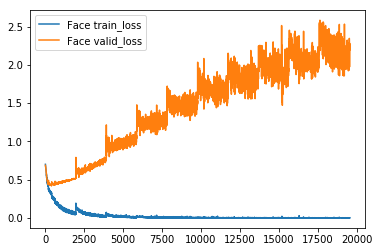

In [26]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='Face train_loss')
mplot.plot(valid_loss, label='Face valid_loss')
mplot.legend()
mplot.show()

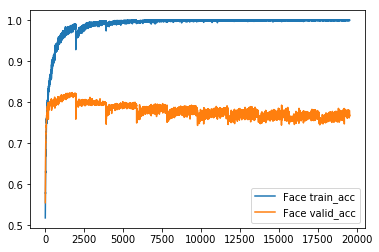

In [27]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc, label='Face train_acc')
mplot.plot(valid_acc, label='Face valid_acc')
mplot.legend()
mplot.show()

In [28]:
test_acc, test_loss = [], []

with tf.Session() as sess:
    # Restore the validated model
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
    
    ################## Test
    acc_batch = []
    loss_batch = []    
    # Loop over batches
    for x, y in get_batches(batch_size=100, X=X_test_norm, y=Y_test_onehot):

        # Feed dictionary
        feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

        # Loss
        loss, acc = sess.run([cost, accuracy], feed_dict = feed)
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Store
    test_acc.append(np.mean(acc_batch))
    test_loss.append(np.mean(loss_batch))

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(test_loss)),
          "Test acc: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints/dcnn-face-yalda-Copy6.ckpt
Test loss: 0.897285 Test acc: 0.896071
